**Employee Attrition Analysis using Logistic Regression - Optimisation via Correlation Analysis**

* Step 1 - Pre-process data

* Step 2 - Create a Logistic Regression Model

* Step 3 - Evaluate the Model

* Step 4 - Calculate feature importance using correlation analysis

* Step 5 - Optimise the Model

* Step 6 - Evaluate the Model, post optimisation

In [133]:
# Import dependencies
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Import password
from passwords import postgres_password

In [134]:
# Establish the connection to postgres database
conn = psycopg2.connect(database = "project_4",
                        user = "postgres",
                        password = postgres_password,
                        host = "localhost",
                        port = "5432"
)

# Import and read the employee_attrition.csv from SQL
attrition_df = pd.read_sql_query('''SELECT * FROM attrition''', conn)

# Close the connection
conn.close()

C:\Users\danie\AppData\Local\Temp\ipykernel_17696\4226612750.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  attrition_df = pd.read_sql_query('''SELECT * FROM attrition''', conn)


In [135]:
# Review dataframe
attrition_df.head()

,age,attrition,businesstravel,dailyrate,department,distancefromhome,education,educationfield,employeecount,employeenumber,...,relationshipsatisfaction,standardhours,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


Step 1 - Pre-process data

In [136]:
# Drop unnecessary and redundant columns
del attrition_df["employeecount"]
del attrition_df["employeenumber"]
del attrition_df["over18"]
del attrition_df["standardhours"]

attrition_df.head()

,age,attrition,businesstravel,dailyrate,department,distancefromhome,education,educationfield,environmentsatisfaction,gender,...,performancerating,relationshipsatisfaction,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,3,4,1,6,3,3,2,2,2,2


In [137]:
# Create a custum function to encode binary columns
def encode_column(column):
    if (column == "Yes") | (column == "Male"):
        return 1
    else:
        return 0

In [138]:
# Apply custom function to columns with binary data
attrition_df["attrition"] = attrition_df["attrition"].apply(encode_column)
attrition_df["gender"] = attrition_df["gender"].apply(encode_column)
attrition_df["overtime"] = attrition_df["overtime"].apply(encode_column)
optimisation_df = attrition_df.copy()
attrition_df.head()

,age,attrition,businesstravel,dailyrate,department,distancefromhome,education,educationfield,environmentsatisfaction,gender,...,performancerating,relationshipsatisfaction,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,0,...,3,1,0,8,0,1,6,4,0,5
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,1,...,4,4,1,10,3,3,10,7,1,7
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,4,1,...,3,2,0,7,3,3,0,0,0,0
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,0,...,3,3,0,8,3,3,8,7,3,0
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,1,1,...,3,4,1,6,3,3,2,2,2,2


In [139]:
# Encode categorical data to numeric with "pd.get_dummies"
converted_df = pd.get_dummies(attrition_df, columns=["businesstravel", "department", "educationfield", "jobrole", "maritalstatus"], dtype="int")
converted_df.head()

,age,attrition,dailyrate,distancefromhome,education,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,...,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Divorced,maritalstatus_Married,maritalstatus_Single
0,41,1,1102,1,2,2,0,94,3,2,...,0,0,0,0,0,1,0,0,0,1
1,49,0,279,8,1,3,1,61,2,2,...,0,0,0,0,1,0,0,0,1,0
2,37,1,1373,2,2,4,1,92,2,1,...,1,0,0,0,0,0,0,0,0,1
3,33,0,1392,3,4,4,0,56,3,1,...,0,0,0,0,1,0,0,0,1,0
4,27,0,591,2,1,1,1,40,3,1,...,1,0,0,0,0,0,0,0,1,0


Step 2 - Create a Logistic Regression Model

In [140]:
# Split our preprocessed data into our features and target arrays
y = converted_df["attrition"]
X = converted_df.drop(columns=["attrition"])

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=1,
                                                    stratify=y)

In [141]:
# Review targets
pd.DataFrame(y).head()

,attrition
0,1
1,0
2,1
3,0
4,0


In [142]:
# Review features
X.head()

,age,dailyrate,distancefromhome,education,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobsatisfaction,...,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Divorced,maritalstatus_Married,maritalstatus_Single
0,41,1102,1,2,2,0,94,3,2,4,...,0,0,0,0,0,1,0,0,0,1
1,49,279,8,1,3,1,61,2,2,2,...,0,0,0,0,1,0,0,0,1,0
2,37,1373,2,2,4,1,92,2,1,3,...,1,0,0,0,0,0,0,0,0,1
3,33,1392,3,4,4,0,56,3,1,3,...,0,0,0,0,1,0,0,0,1,0
4,27,591,2,1,1,1,40,3,1,2,...,1,0,0,0,0,0,0,0,1,0


In [143]:
# Create logistic regerssion model
model = LogisticRegression(solver="lbfgs",
                                max_iter=200,
                                random_state=1)
model

LogisticRegression(max_iter=200, random_state=1)

In [144]:
# Fit training data to model
model.fit(X_train, y_train)

c:\Users\danie\anaconda3\envs\dev\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=200, random_state=1)

In [145]:
# Make predictions on testing data
predictions = model.predict(X_test)
results = pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)
results.head()

,Prediction,Actual
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


Step 3 - Evaluate the Model

In [146]:
# Display the accuracy score for the test dataset.
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, predictions)}")

Logistic Regression Accuracy: 0.8288043478260869


In [147]:
# Print the classification report for the model
target_names = ["Attrition", "No Attrition"]
print(classification_report(y_test, predictions, target_names = target_names))

              precision    recall  f1-score   support

   Attrition       0.84      0.98      0.91       309
No Attrition       0.17      0.02      0.03        59

    accuracy                           0.83       368
   macro avg       0.50      0.50      0.47       368
weighted avg       0.73      0.83      0.77       368



In [148]:
# Generate the confusion matrix for the model
conf_matrix = confusion_matrix(y_test, predictions)
conf_matrix


array([[304,   5],
       [ 58,   1]], dtype=int64)

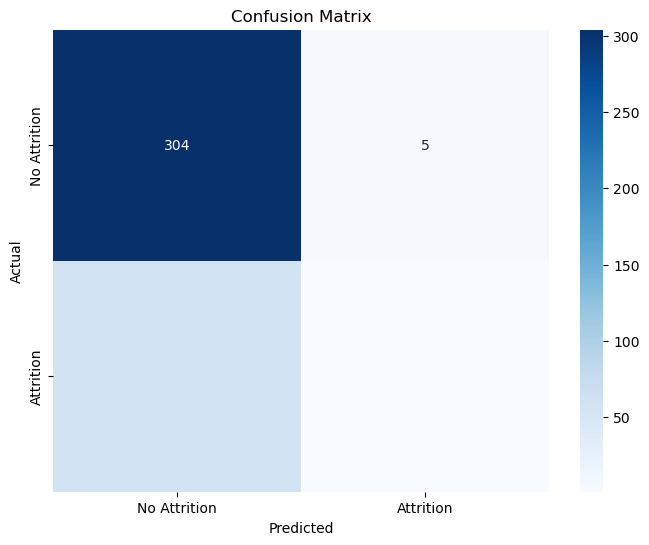

In [149]:
# Visualise the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Attrition", "Attrition"], yticklabels=["No Attrition", "Attrition"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("output/confusion_matrix", bbox_inches = 'tight')
plt.show()

Step 4 - Calculate feature importance using correlation analysis

In [150]:
# Compute the correlation matrix
corr_matrix = converted_df.corr()

corr_matrix

,age,attrition,dailyrate,distancefromhome,education,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,...,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Divorced,maritalstatus_Married,maritalstatus_Single
age,1.000000,-0.159205,0.010661,-0.001686,0.208034,0.010146,-0.036311,0.024287,0.029820,0.509604,...,-0.143176,0.294248,0.049726,0.185891,-0.146518,-0.002001,-0.175785,0.033120,0.083919,-0.119185
attrition,-0.159205,1.000000,-0.056652,0.077924,-0.031373,-0.103369,0.029453,-0.006846,-0.130016,-0.169105,...,0.098290,-0.083316,-0.082994,-0.088870,-0.000360,0.019774,0.157234,-0.087716,-0.090984,0.175419
dailyrate,0.010661,-0.056652,1.000000,-0.004985,-0.016806,0.018355,-0.011716,0.023381,0.046135,0.002966,...,-0.006728,-0.013224,-0.005302,-0.000021,-0.002624,-0.000513,0.005375,0.037080,0.040035,-0.075835
distancefromhome,-0.001686,0.077924,-0.004985,1.000000,0.021042,-0.016075,-0.001851,0.031131,0.008783,0.005303,...,0.012369,-0.039190,0.011848,-0.022351,-0.010986,0.030761,-0.015994,-0.005440,0.030232,-0.027445
education,0.208034,-0.031373,-0.016806,0.021042,1.000000,-0.027128,-0.016547,0.016775,0.042438,0.101589,...,-0.063566,0.028453,-0.005290,0.049694,0.000709,0.053398,-0.091465,-0.002439,-0.001865,0.004168
environmentsatisfaction,0.010146,-0.103369,0.018355,-0.016075,-0.027128,1.000000,0.000508,-0.049857,-0.008278,0.001212,...,-0.001533,0.010730,0.059178,-0.048689,0.001940,-0.024421,0.002949,0.016439,-0.022180,0.009035
gender,-0.036311,0.029453,-0.011716,-0.001851,-0.016547,0.000508,1.000000,-0.000478,0.017960,-0.039403,...,0.067793,-0.033880,-0.065197,-0.006121,0.009745,-0.005348,-0.028877,0.046076,-0.007804,-0.032752
hourlyrate,0.024287,-0.006846,0.023381,0.031131,0.016775,-0.049857,-0.000478,1.000000,0.042861,-0.027853,...,0.018028,0.012659,-0.014394,-0.025128,0.020034,-0.011886,-0.018703,-0.006150,0.036432,-0.033436
jobinvolvement,0.029820,-0.130016,0.046135,0.008783,0.042438,-0.008278,0.017960,0.042861,1.000000,-0.012630,...,-0.022724,0.017112,-0.021939,0.015200,0.047604,-0.011413,-0.027282,0.016815,0.028324,-0.045253
joblevel,0.509604,-0.169105,0.002966,0.005303,0.101589,0.001212,-0.039403,-0.027853,-0.012630,1.000000,...,-0.344608,0.552744,0.114896,0.414319,-0.387788,0.127490,-0.216559,0.037087,0.050547,-0.087072


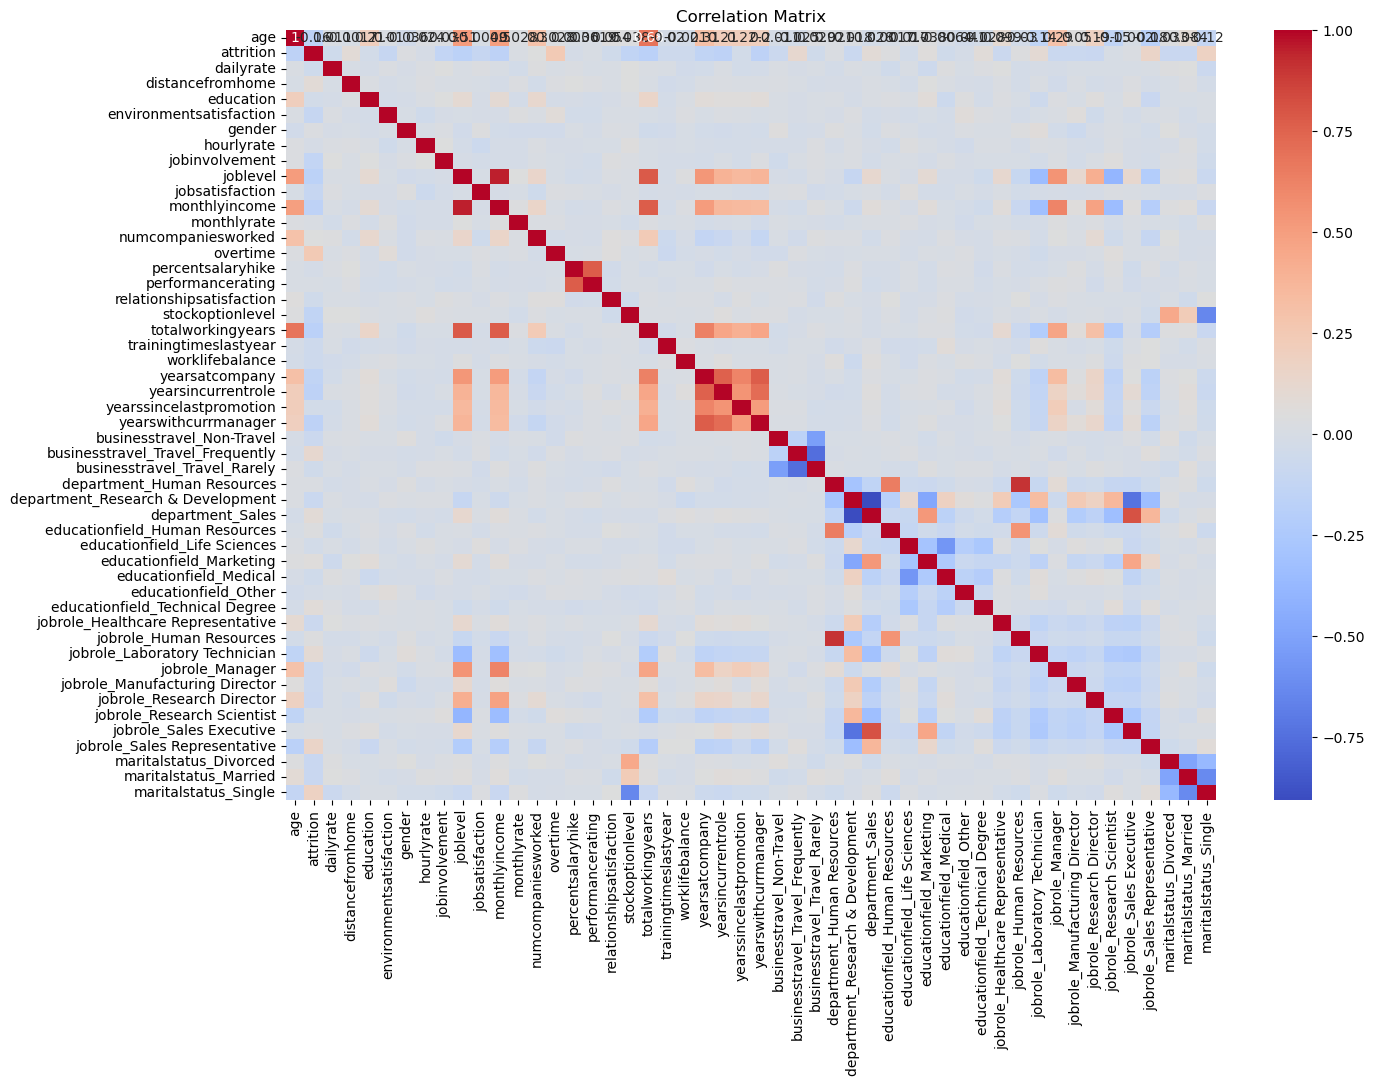

In [151]:
# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.savefig("output/correlation_matrix", bbox_inches = 'tight')
plt.show()


In [152]:
# Correlation with target variable 'Attrition_Yes'
corr_target = corr_matrix["attrition"].sort_values(ascending=False)

# Create a dataframe
corr_target_df = pd.DataFrame(corr_target)

# Review dataframe to see which variables have the strongest correlation with attrition
corr_target_df


,attrition
attrition,1.000000
overtime,0.246118
maritalstatus_Single,0.175419
jobrole_Sales Representative,0.157234
businesstravel_Travel_Frequently,0.115143
jobrole_Laboratory Technician,0.098290
department_Sales,0.080855
distancefromhome,0.077924
educationfield_Technical Degree,0.069355
educationfield_Marketing,0.055781


Step 5 - Optimise the model

In [153]:
# Retrain the model, this time using only the 3 most important features
optimisation_df = optimisation_df[["attrition", "overtime", "jobrole"]]

converted_df_optimisation = pd.get_dummies(optimisation_df, columns=["jobrole"], dtype="int")

y = converted_df_optimisation["attrition"]
X = converted_df_optimisation.drop(columns="attrition")

In [154]:
# Split the optimised dataset into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=1,
                                                    stratify=y)

In [155]:
# Fit the optimised data to the model
model.fit(X_train, y_train)

LogisticRegression(max_iter=200, random_state=1)

In [156]:
# Make predictions on testing data
predictions = model.predict(X_test)
results = pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)
results.head()

,Prediction,Actual
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


Step 6 - Evaluate the Model, post optimisation

In [157]:
# Display the accuracy score for the test dataset.
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, predictions)}")

Logistic Regression Accuracy: 0.8505434782608695


In [158]:
# Print the classification report for the optimised model
target_names = ["Attrition", "No Attrition"]
print(classification_report(y_test, predictions, target_names = target_names))

              precision    recall  f1-score   support

   Attrition       0.85      0.99      0.92       309
No Attrition       0.75      0.10      0.18        59

    accuracy                           0.85       368
   macro avg       0.80      0.55      0.55       368
weighted avg       0.84      0.85      0.80       368



In [159]:
# Generate the confusion matrix for the optimised model
conf_matrix = confusion_matrix(y_test, predictions)
conf_matrix

array([[307,   2],
       [ 53,   6]], dtype=int64)

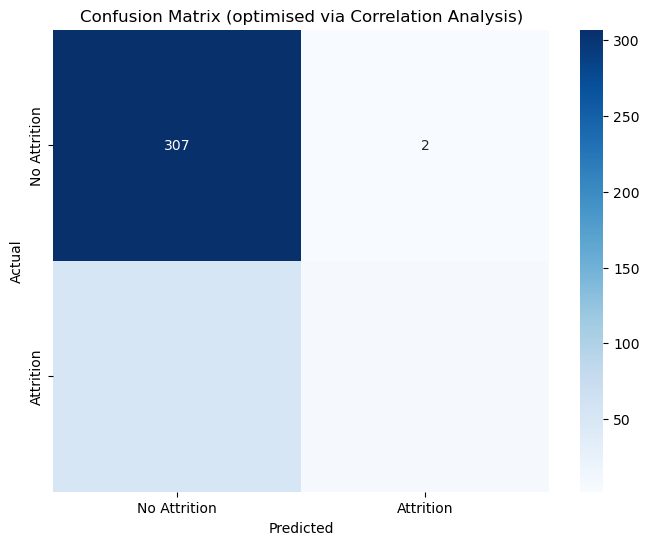

In [160]:
# Visualise the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Attrition", "Attrition"], yticklabels=["No Attrition", "Attrition"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (optimised via Correlation Analysis)")
plt.savefig("output/confusion_matrix_optimisation_corr_analysis", bbox_inches = 'tight')
plt.show()